# Model Pipelines in Sklearn

<div class="admonition-main-idea admonition">
<p class="admonition-title">Main Idea</p>
<p>Version control is a <strong>system</strong> that <strong>tracks changes</strong> to files <strong>over time</strong>.</p>
</div>

In [1]:
# This code spits out lots of warnings. We turn them off for the purposes of this tutorial. 
# This is bad practice in general. Only use if you already know your code is correct. 
import warnings
import os
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
os.environ['PYTHONWARNINGS']='ignore'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t

In [3]:
!pip install -U scikit-learn

Defaulting to user installation because normal site-packages is not writeable


In [4]:
import sklearn
assert sklearn.__version__ > '1.2'

In [5]:
from sklearn import set_config
set_config(transform_output = "pandas")

## The Data

In [6]:
df = pd.read_csv('/zfs/citi/workshop_data/python_ml/ames_train.csv')
df.shape

(1460, 81)

In [7]:
features = pd.read_csv('/zfs/citi/workshop_data/python_ml/ames_features.csv')
features

,variable,type,description
0,SalePrice,numeric,the property's sale price in dollars. This is ...
1,MSSubClass,categorical,The building class
2,MSZoning,categorical,The general zoning classification
3,LotFrontage,numeric,Linear feet of street connected to property
4,LotArea,numeric,Lot size in square feet
...,...,...,...
75,MiscVal,numeric,$Value of miscellaneous feature
76,MoSold,numeric,Month Sold
77,YrSold,numeric,Year Sold
78,SaleType,categorical,Type of sale


## Exploratory Analysis

array([[<AxesSubplot:title={'center':'SalePrice'}>]], dtype=object)

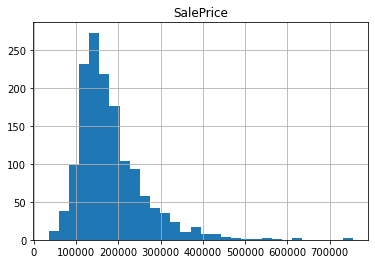

In [8]:
# it's always a good idea to look at your response variable
df.hist('SalePrice', bins=30)

It wouldn't be a bad idea to apply Box-Cox if using a linear model. 

In [9]:
# we should make sure that no SalePrice values are missing
df.SalePrice.isna().any()

False

In [10]:
# it's also important to look at the degree of missingness in each of your features
column_missingness = df.isna().sum().sort_values(ascending=False) / len(df)
column_missingness.head(15)

PoolQC          0.995205
MiscFeature     0.963014
Alley           0.937671
Fence           0.807534
FireplaceQu     0.472603
LotFrontage     0.177397
GarageYrBlt     0.055479
GarageCond      0.055479
GarageType      0.055479
GarageFinish    0.055479
GarageQual      0.055479
BsmtFinType2    0.026027
BsmtExposure    0.026027
BsmtQual        0.025342
BsmtCond        0.025342
dtype: float64

Let's go ahead and drop `PoolQC`, `MiscFeature`, and `Alley` as these are almost always missing. Note that some of these should be treated with more nuance. Take `Fence` for instance. I expect `Fence` takes the value NA when no fence is present. 

In [11]:
features_to_drop = ['PoolQC', 'MiscFeature', 'Alley']
df = df.drop(features_to_drop, axis=1)
features = features[~features.variable.isin(features_to_drop)]
df.shape, features.shape

((1460, 78), (77, 3))

In [12]:
# Let's see if any rows are missing a large portion of their data
row_missingness = df.isna().sum(axis=1).sort_values(ascending=False) / len(df.columns)
row_missingness

39      0.153846
533     0.153846
520     0.153846
1011    0.153846
1218    0.153846
          ...   
860     0.000000
51      0.000000
1170    0.000000
642     0.000000
810     0.000000
Length: 1460, dtype: float64

In [13]:
# let's take a closer look at some of these
index=39
df.loc[index, df.loc[index].isna()]

BsmtQual        NaN
BsmtCond        NaN
BsmtExposure    NaN
BsmtFinType1    NaN
BsmtFinType2    NaN
FireplaceQu     NaN
GarageType      NaN
GarageYrBlt     NaN
GarageFinish    NaN
GarageQual      NaN
GarageCond      NaN
Fence           NaN
Name: 39, dtype: object

Nothing too concerning here. Most of these features are very niche.

In [14]:
# get lists of categorical and numeric features
categorical_features = features.variable[features.type=='categorical'].tolist()
numeric_features = features.variable[features.type=='numeric'].tolist()[1:]
len(categorical_features), len(numeric_features)

(42, 34)

In [15]:
# let's take a look at our categorical features
categorical_features

['MSSubClass',
 'MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'Fireplaces',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'Fence',
 'SaleType',
 'SaleCondition']

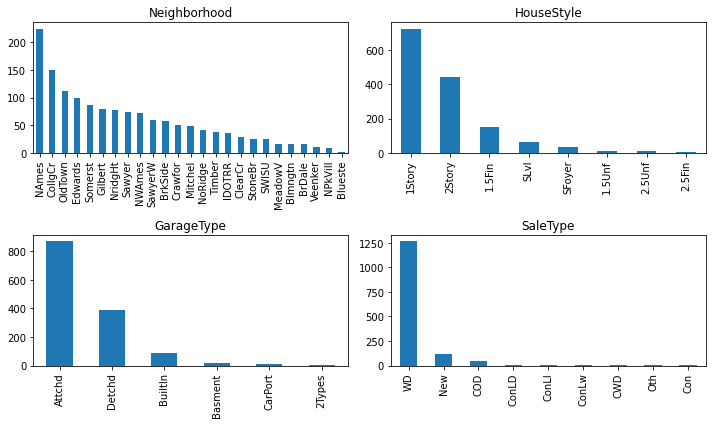

In [16]:
# Let's look at the distribution of features
plot_features = ['Neighborhood', 'HouseStyle', 'GarageType', 'SaleType']
fig, axes = plt.subplots(2,2)
fig.set_size_inches(10,6)
axes = axes.flatten()
for ix, feature in enumerate(plot_features):
    df[feature].value_counts().plot(kind='bar', ax=axes[ix])
    axes[ix].set_title(feature)
plt.tight_layout()

In [17]:
# let's take a look at our categorical features
numeric_features

['LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

In [18]:
# since these are numeric, we can compute some basic stats:
df[numeric_features].describe()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,...,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753
std,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,...,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095
min,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,...,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,...,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,...,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,...,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000


Probably, most of these should be rescaled with standard scaling. 

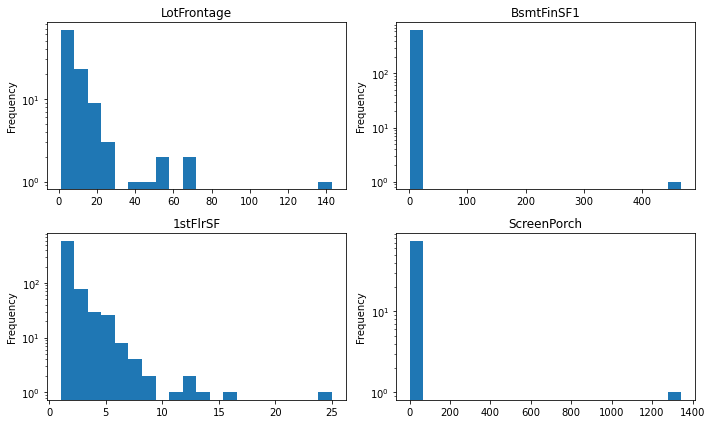

In [19]:
# Let's look at the distribution of features
plot_features = ['LotFrontage', 'BsmtFinSF1', '1stFlrSF', 'ScreenPorch']
fig, axes = plt.subplots(2,2)
fig.set_size_inches(10,6)
axes = axes.flatten()
for ix, feature in enumerate(plot_features):
    df[feature].value_counts().plot(kind='hist', ax=axes[ix], bins=20, logy=True)
    axes[ix].set_title(feature)
plt.tight_layout()

Some of these features have very low variance. They should probably be removed. Others should possibly be transformed using Box-Cox or similar. 

<Figure size 720x576 with 0 Axes>

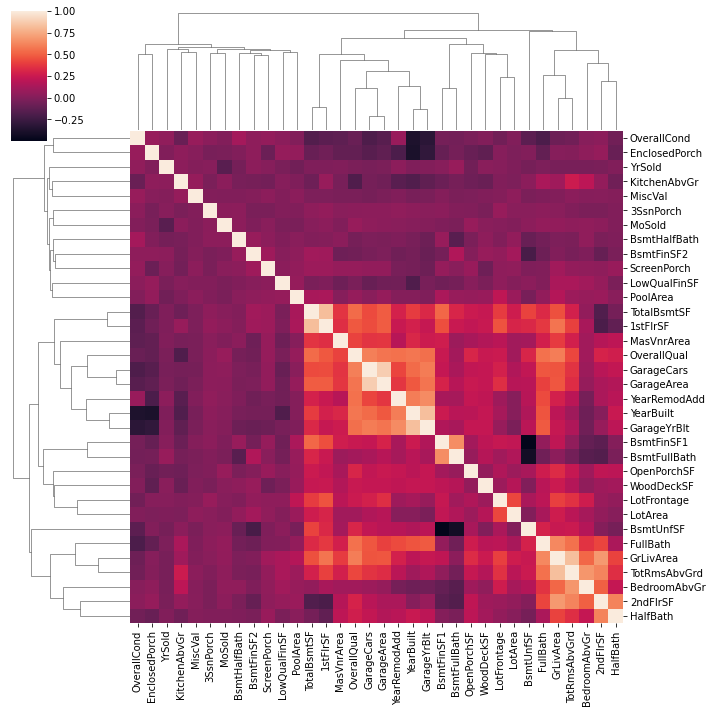

In [20]:
# Let's check to see if any of our numeric features are highly correlated with one another
import seaborn as sns
plt.gcf().set_size_inches(10,8)
sns.clustermap(df[numeric_features].corr())

Overall, our features are relatively uncorrelated. Some features are highly correlated. For instance: 
* TotalBsmtSF, 1stFlrSF
* GarageCars, GarageArea
* BsmtFnSF1, BsmtFullBath

We could consider removing some of these near duplicate features. 

## First pass
It's usually a good idea to first perform a quick and dirty analysis ignoring the subtleties that we discussed above. We can then try to incorporate these ideas to improve our results. 

In [21]:
# define input/target
inputs = features.variable.iloc[1:].tolist()
X, y = df[inputs], df['SalePrice']
X.shape, y.shape

((1460, 76), (1460,))

In [22]:
# split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
X_train.shape, X_test.shape

((1168, 76), (292, 76))

### Preprocessing numeric and categorical features
We will use scikit-learn's pipeline feature to streamline the model fitting and evaluation process. 

In [23]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer

# preprocessing pipeline for numeric quantities
preproc_numeric = Pipeline([
    ('fill_na', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])

# preprocessing pipeline for categorical quantities
preproc_categorical = Pipeline([
    ('fill_na', SimpleImputer(strategy='most_frequent')),
    ('encode', OneHotEncoder(sparse_output=False, drop='first', min_frequency=5, handle_unknown='infrequent_if_exist'))
])

# full preprocessing pipeline
preproc = ColumnTransformer(
    transformers=[
    ('numeric', preproc_numeric, numeric_features),
    ('categorical', preproc_categorical, categorical_features)
], verbose_feature_names_out=False)

preproc.fit(X_train)

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('fill_na',
                                                  SimpleImputer(strategy='median')),
                                                 ('scale', StandardScaler())]),
                                 ['LotFrontage', 'LotArea', 'OverallQual',
                                  'OverallCond', 'YearBuilt', 'YearRemodAdd',
                                  'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
                                  'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
                                  '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
                                  'BsmtFullBath', 'BsmtHal...
                                  'LotShape', 'LandContour', 'Utilities',
                                  'LotConfig', 'LandSlope', 'Neighborhood',
                                  'Condition1', 'Condition2', 'BldgType',
                                  'HouseStyle', 'RoofStyle', 'RoofMatl',
                                  'Exterior1st', 'Exterior2nd', 'MasVnrType',
                                  'ExterQual', 'ExterCond', 'Foundation',
                                  'BsmtQual', 'BsmtCond', 'BsmtExposure',
                                  'BsmtFinType1', 'BsmtFinType2', 'Heating',
                                  'HeatingQC', 'CentralAir', 'Electrical', ...])],
                  verbose_feature_names_out=False)

In [24]:
preproc.transform(X_test)

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,Fence_MnWw,SaleType_ConLD,SaleType_New,SaleType_WD,SaleType_infrequent_sklearn,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_infrequent_sklearn
892,-0.012468,-0.211594,-0.088934,2.165000,-0.259789,0.873470,-0.597889,0.472844,-0.285504,-0.391317,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1105,1.234520,0.145643,1.374088,-0.524174,0.751222,0.487465,1.498567,1.276986,-0.285504,-0.312872,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
413,-0.635963,-0.160826,-0.820445,0.372217,-1.433867,-1.683818,-0.597889,-0.971996,-0.285504,0.980347,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
522,-0.903175,-0.529035,-0.088934,1.268609,-0.781602,-1.683818,-0.597889,-0.102477,-0.285504,0.077111,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1036,0.833703,0.205338,2.105599,-0.524174,1.175195,1.114724,-0.192497,1.255193,-0.285504,0.061422,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,-0.903175,-0.443026,-1.551955,1.268609,-1.107734,0.728718,1.921333,-0.605882,-0.285504,0.377443,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1361,2.392439,0.508459,0.642577,-0.524174,1.109968,0.969972,-0.505228,1.804363,-0.285504,-0.705096,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
802,-0.324216,-0.231585,0.642577,-0.524174,1.109968,0.969972,-0.597889,0.440155,-0.285504,-1.099561,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
651,-0.457822,-0.149296,-1.551955,-0.524174,-1.009895,-1.683818,-0.597889,-0.971996,-0.285504,0.413303,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


### Model fitting

In [25]:
# create the model pipeline
from sklearn.linear_model import Ridge

pipe = Pipeline([
    ('preproc', preproc), 
    ('estimator', Ridge(alpha=1))
])

# fit
pipe.fit(X_train, y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('fill_na',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['LotFrontage', 'LotArea',
                                                   'OverallQual', 'OverallCond',
                                                   'YearBuilt', 'YearRemodAdd',
                                                   'MasVnrArea', 'BsmtFinSF1',
                                                   'BsmtFinSF2', 'BsmtUnfSF',
                                                   'TotalBsmtSF', '1stFlrSF',
                                                   '2ndFlrSF', 'LowQualFinSF',
                                                   'GrLivAr...
                                                   'Neighborhood', 'Condition1',
                                                   'Condition2', 'BldgType',
                                                   'HouseStyle', 'RoofStyle',
                                                   'RoofMatl', 'Exterior1st',
                                                   'Exterior2nd', 'MasVnrType',
                                                   'ExterQual', 'ExterCond',
                                                   'Foundation', 'BsmtQual',
                                                   'BsmtCond', 'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', ...])],
                                   verbose_feature_names_out=False)),
                ('estimator', Ridge(alpha=1))])

### Model evaluation

In [26]:
# evaluate
# For random forest regressor, score returns the R^2 value
print("Train R^2:", pipe.score(X_train, y_train))
print("Test R^2:", pipe.score(X_test, y_test))

Train R^2: 0.9028881797596011
Test R^2: 0.8714648323729995


In [27]:
# MAE is a more intuitive metric for price estimation
from sklearn.metrics import mean_absolute_error
y_train_pred_1stpass = pipe.predict(X_train)
y_test_pred_1stpass = pipe.predict(X_test)
print("Train MAE:", mean_absolute_error(y_train, y_train_pred_1stpass))
print("Test MAE:", mean_absolute_error(y_test, y_test_pred_1stpass))

Train MAE: 15288.339516024189
Test MAE: 20544.401602914677


In [28]:
# more robust classification with cross validation
from sklearn.model_selection import KFold, cross_validate
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_validate(pipe, X, y, n_jobs=4, return_train_score=True, scoring='neg_mean_absolute_error')
cv_scores

{'fit_time': array([0.16545057, 0.14652419, 0.1494379 , 0.14467359, 0.12987018]),
 'score_time': array([0.03685045, 0.03611279, 0.03650355, 0.03635812, 0.03367758]),
 'test_score': array([-18480.22849655, -20702.55584883, -20390.70685371, -17442.23199009,
        -19762.00113844]),
 'train_score': array([-15920.87447649, -14995.07168281, -15245.2950543 , -15810.8980323 ,
        -13704.36598872])}

In [29]:
import scipy
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, (m-h, m+h)

mean_confidence_interval(-cv_scores['test_score'])

(19355.544865524786, (17657.804810833954, 21053.284920215618))

## Optimizing the pipeline

There are many things we can try to improve the fit of our model. For example, we could experiment with the following: 
* apply some of the observations from our exploratory data analysis
* different imputation strategies
* add a dimension reduction step like PCA
* try different estimators
* try hyperparameters within different estimators

How do we start testing various approaches in scikit-learn? One way is to manually change the pipeline we defined above, fit/evaluate the model, and compare with our results above. This can be a tedious and error-prone process. Let's see how do this efficiently using scikit-learn's APIs. 

To introduce the ideas, let's consider the alpha regularization parameter used in Ridge regression.

### Tuning estimator parameters

In [30]:
pipe

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('fill_na',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['LotFrontage', 'LotArea',
                                                   'OverallQual', 'OverallCond',
                                                   'YearBuilt', 'YearRemodAdd',
                                                   'MasVnrArea', 'BsmtFinSF1',
                                                   'BsmtFinSF2', 'BsmtUnfSF',
                                                   'TotalBsmtSF', '1stFlrSF',
                                                   '2ndFlrSF', 'LowQualFinSF',
                                                   'GrLivAr...
                                                   'Neighborhood', 'Condition1',
                                                   'Condition2', 'BldgType',
                                                   'HouseStyle', 'RoofStyle',
                                                   'RoofMatl', 'Exterior1st',
                                                   'Exterior2nd', 'MasVnrType',
                                                   'ExterQual', 'ExterCond',
                                                   'Foundation', 'BsmtQual',
                                                   'BsmtCond', 'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', ...])],
                                   verbose_feature_names_out=False)),
                ('estimator', Ridge(alpha=1))])

In [31]:
from sklearn.model_selection import GridSearchCV
alphas = np.logspace(-2,3,10)
param_grid = {
    'estimator__alpha': alphas
}
cv = KFold(10, shuffle=True)
gs = GridSearchCV(pipe, param_grid, cv=cv, n_jobs=10, scoring='neg_mean_absolute_error', verbose=False)

gs.fit(X_train, y_train)
gs.best_estimator_

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('fill_na',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['LotFrontage', 'LotArea',
                                                   'OverallQual', 'OverallCond',
                                                   'YearBuilt', 'YearRemodAdd',
                                                   'MasVnrArea', 'BsmtFinSF1',
                                                   'BsmtFinSF2', 'BsmtUnfSF',
                                                   'TotalBsmtSF', '1stFlrSF',
                                                   '2ndFlrSF', 'LowQualFinSF',
                                                   'GrLivAr...
                                                   'Neighborhood', 'Condition1',
                                                   'Condition2', 'BldgType',
                                                   'HouseStyle', 'RoofStyle',
                                                   'RoofMatl', 'Exterior1st',
                                                   'Exterior2nd', 'MasVnrType',
                                                   'ExterQual', 'ExterCond',
                                                   'Foundation', 'BsmtQual',
                                                   'BsmtCond', 'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', ...])],
                                   verbose_feature_names_out=False)),
                ('estimator', Ridge(alpha=21.544346900318846))])

In [32]:
# look at the grid search outcome
gs.cv_results_

{'mean_fit_time': array([0.21524832, 0.12929206, 0.14147673, 0.13001094, 0.12876217,
        0.12753346, 0.12873785, 0.12855723, 0.12965353, 0.1284827 ]),
 'std_fit_time': array([0.03227405, 0.00410048, 0.0115528 , 0.00307046, 0.00154043,
        0.00228009, 0.00147471, 0.00239597, 0.00322923, 0.00289472]),
 'mean_score_time': array([0.03430345, 0.03392034, 0.03475215, 0.03282845, 0.03321393,
        0.03305686, 0.03315287, 0.03283639, 0.03680825, 0.03171299]),
 'std_score_time': array([0.00137619, 0.00102129, 0.00133493, 0.00081006, 0.00101256,
        0.00059905, 0.00092702, 0.00072003, 0.00701796, 0.00133118]),
 'param_estimator__alpha': masked_array(data=[0.01, 0.03593813663804628, 0.1291549665014884,
                    0.464158883361278, 1.6681005372000592,
                    5.994842503189409, 21.544346900318846,
                    77.42636826811278, 278.2559402207126, 1000.0],
              mask=[False, False, False, False, False, False, False, False,
                    Fals

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('fill_na',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['LotFrontage', 'LotArea',
                                                   'OverallQual', 'OverallCond',
                                                   'YearBuilt', 'YearRemodAdd',
                                                   'MasVnrArea', 'BsmtFinSF1',
                                                   'BsmtFinSF2', 'BsmtUnfSF',
                                                   'TotalBsmtSF', '1stFlrSF',
                                                   '2ndFlrSF', 'LowQualFinSF',
                                                   'GrLivAr...
                                                   'Neighborhood', 'Condition1',
                                                   'Condition2', 'BldgType',
                                                   'HouseStyle', 'RoofStyle',
                                                   'RoofMatl', 'Exterior1st',
                                                   'Exterior2nd', 'MasVnrType',
                                                   'ExterQual', 'ExterCond',
                                                   'Foundation', 'BsmtQual',
                                                   'BsmtCond', 'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', ...])],
                                   verbose_feature_names_out=False)),
                ('estimator', Ridge(alpha=21.544346900318846))])

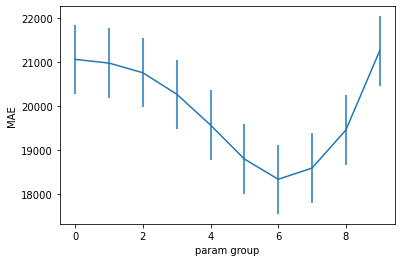

In [33]:
# visualize the search grid
def plot_cv_results(res, confidence=0.95):
    n = len(res['mean_test_score'])
    sem = scipy.stats.sem(res['mean_test_score'])
    t = scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    plt.errorbar(x=range(n), y=-res['mean_test_score'], yerr=t*sem, linetype=None)
    plt.xlabel('param group')
    plt.ylabel('MAE')
    
plot_cv_results(gs.cv_results_)
gs.best_estimator_

In [34]:
# print stats for each parameter group
def analyze_cv_results(cv_results):
    split_results = np.vstack([val for key, val in cv_results.items() if 'split' in key])
    
    for ix, p in enumerate(cv_results['params']): 
        if ix>0:
            print('-'*30)
        print(f"Parameter group {ix}:", p)
        mu, (lo, hi) = mean_confidence_interval(-split_results[:,ix])
        print(f"\tMean score: {mu:0.2f}")
        print(f"\t95% CI: ({lo:0.2f}, {hi:0.2f})")

analyze_cv_results(gs.cv_results_)

Parameter group 0: {'estimator__alpha': 0.01}
	Mean score: 21054.51
	95% CI: (19528.22, 22580.80)
------------------------------
Parameter group 1: {'estimator__alpha': 0.03593813663804628}
	Mean score: 20969.38
	95% CI: (19455.37, 22483.39)
------------------------------
Parameter group 2: {'estimator__alpha': 0.1291549665014884}
	Mean score: 20749.62
	95% CI: (19260.16, 22239.07)
------------------------------
Parameter group 3: {'estimator__alpha': 0.464158883361278}
	Mean score: 20263.11
	95% CI: (18808.89, 21717.33)
------------------------------
Parameter group 4: {'estimator__alpha': 1.6681005372000592}
	Mean score: 19560.93
	95% CI: (18161.96, 20959.89)
------------------------------
Parameter group 5: {'estimator__alpha': 5.994842503189409}
	Mean score: 18790.41
	95% CI: (17412.15, 20168.66)
------------------------------
Parameter group 6: {'estimator__alpha': 21.544346900318846}
	Mean score: 18330.32
	95% CI: (16920.62, 19740.02)
------------------------------
Parameter grou

We get the best mean performance for parameter group 6 with alpha=21.54.

### Searching over multiple parameters simultaneously

Often we will want to search over multiple parameters at the same time. This is easy.

In [35]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'preproc__numeric__fill_na__strategy': ['mean', 'median', 'most_frequent'],
    'preproc__categorical__encode__min_frequency': [1, 2, 3, 4, 5],
    'estimator__alpha': [21.54]
}
cv = KFold(10, shuffle=True)
gs = GridSearchCV(pipe, param_grid, cv=cv, n_jobs=10, scoring='neg_mean_absolute_error', verbose=True)
gs.fit(X_train, y_train)
gs.best_estimator_

Fitting 10 folds for each of 15 candidates, totalling 150 fits


Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('fill_na',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['LotFrontage', 'LotArea',
                                                   'OverallQual', 'OverallCond',
                                                   'YearBuilt', 'YearRemodAdd',
                                                   'MasVnrArea', 'BsmtFinSF1',
                                                   'BsmtFinSF2', 'BsmtUnfSF',
                                                   'TotalBsmtSF', '1stFlrSF',
                                                   '2ndFlrSF', 'LowQualFinSF',
                                                   '...
                                                   'Neighborhood', 'Condition1',
                                                   'Condition2', 'BldgType',
                                                   'HouseStyle', 'RoofStyle',
                                                   'RoofMatl', 'Exterior1st',
                                                   'Exterior2nd', 'MasVnrType',
                                                   'ExterQual', 'ExterCond',
                                                   'Foundation', 'BsmtQual',
                                                   'BsmtCond', 'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', ...])],
                                   verbose_feature_names_out=False)),
                ('estimator', Ridge(alpha=21.54))])

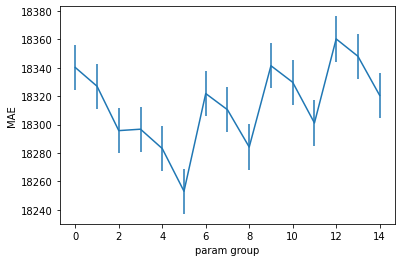

In [36]:
plot_cv_results(gs.cv_results_)

In [37]:
analyze_cv_results(gs.cv_results_)

Parameter group 0: {'estimator__alpha': 21.54, 'preproc__categorical__encode__min_frequency': 1, 'preproc__numeric__fill_na__strategy': 'mean'}
	Mean score: 18340.20
	95% CI: (16399.35, 20281.04)
------------------------------
Parameter group 1: {'estimator__alpha': 21.54, 'preproc__categorical__encode__min_frequency': 1, 'preproc__numeric__fill_na__strategy': 'median'}
	Mean score: 18326.99
	95% CI: (16385.40, 20268.58)
------------------------------
Parameter group 2: {'estimator__alpha': 21.54, 'preproc__categorical__encode__min_frequency': 1, 'preproc__numeric__fill_na__strategy': 'most_frequent'}
	Mean score: 18295.73
	95% CI: (16332.00, 20259.46)
------------------------------
Parameter group 3: {'estimator__alpha': 21.54, 'preproc__categorical__encode__min_frequency': 2, 'preproc__numeric__fill_na__strategy': 'mean'}
	Mean score: 18296.74
	95% CI: (16344.75, 20248.73)
------------------------------
Parameter group 4: {'estimator__alpha': 21.54, 'preproc__categorical__encode__min

It looks like the model prefers 'most_frequent' imputation with a OneHotEncoder min frequency of 2. 

### Searching over different transformers

Let's try something a little more drastic. What if we were to replace the imputation approach altogether with a the KNNImputer that we saw earlier in the workshop?

Before, we used GridSearchCV to scan possible values for a parameter in one of our transforms. We can also scan over different transform objects. 

In [38]:
pipe

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('fill_na',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['LotFrontage', 'LotArea',
                                                   'OverallQual', 'OverallCond',
                                                   'YearBuilt', 'YearRemodAdd',
                                                   'MasVnrArea', 'BsmtFinSF1',
                                                   'BsmtFinSF2', 'BsmtUnfSF',
                                                   'TotalBsmtSF', '1stFlrSF',
                                                   '2ndFlrSF', 'LowQualFinSF',
                                                   'GrLivAr...
                                                   'Neighborhood', 'Condition1',
                                                   'Condition2', 'BldgType',
                                                   'HouseStyle', 'RoofStyle',
                                                   'RoofMatl', 'Exterior1st',
                                                   'Exterior2nd', 'MasVnrType',
                                                   'ExterQual', 'ExterCond',
                                                   'Foundation', 'BsmtQual',
                                                   'BsmtCond', 'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', ...])],
                                   verbose_feature_names_out=False)),
                ('estimator', Ridge(alpha=1))])

In [39]:
from sklearn.impute import KNNImputer
param_grid = {
    # before: 'preproc__numeric__fill_na__strategy': ['mean', 'median', 'most_frequent'],
    'preproc__numeric__fill_na': [SimpleImputer(strategy='most_frequent'), KNNImputer(n_neighbors=20, weights="uniform")],
    'preproc__categorical__encode__min_frequency': [2],
    'estimator__alpha': [21.54]
}

gs = GridSearchCV(pipe, param_grid, cv=cv, n_jobs=10, scoring='neg_mean_absolute_error', verbose=True)
gs.fit(X_train, y_train)
gs.best_estimator_

Fitting 10 folds for each of 2 candidates, totalling 20 fits


Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('fill_na',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['LotFrontage', 'LotArea',
                                                   'OverallQual', 'OverallCond',
                                                   'YearBuilt', 'YearRemodAdd',
                                                   'MasVnrArea', 'BsmtFinSF1',
                                                   'BsmtFinSF2', 'BsmtUnfSF',
                                                   'TotalBsmtSF', '1stFlrSF',
                                                   '2ndFlrSF', 'LowQualFinSF',
                                                   '...
                                                   'Neighborhood', 'Condition1',
                                                   'Condition2', 'BldgType',
                                                   'HouseStyle', 'RoofStyle',
                                                   'RoofMatl', 'Exterior1st',
                                                   'Exterior2nd', 'MasVnrType',
                                                   'ExterQual', 'ExterCond',
                                                   'Foundation', 'BsmtQual',
                                                   'BsmtCond', 'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', ...])],
                                   verbose_feature_names_out=False)),
                ('estimator', Ridge(alpha=21.54))])

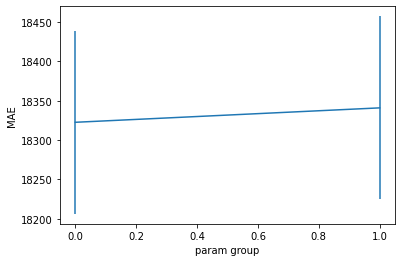

In [40]:
plot_cv_results(gs.cv_results_)

In [41]:
analyze_cv_results(gs.cv_results_)

Parameter group 0: {'estimator__alpha': 21.54, 'preproc__categorical__encode__min_frequency': 2, 'preproc__numeric__fill_na': SimpleImputer(strategy='most_frequent')}
	Mean score: 18322.53
	95% CI: (15369.93, 21275.13)
------------------------------
Parameter group 1: {'estimator__alpha': 21.54, 'preproc__categorical__encode__min_frequency': 2, 'preproc__numeric__fill_na': KNNImputer(n_neighbors=20)}
	Mean score: 18340.86
	95% CI: (15379.45, 21302.27)


We can't distinguish between these two approaches. 

### Searching different estimators
Just like we could search over different transforms, we can search over different estimators. 

In [42]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
                        
param_grid = {
    'preproc__numeric__fill_na': [SimpleImputer(strategy='most_frequent')],
    'preproc__categorical__encode__min_frequency': [2],
    'estimator': [Ridge(alpha=21.54), RandomForestRegressor(), GradientBoostingRegressor()]
}

gs = GridSearchCV(pipe, param_grid, cv=cv, n_jobs=10, scoring='neg_mean_absolute_error', verbose=True)
gs.fit(X_train, y_train)
gs.best_estimator_

Fitting 10 folds for each of 3 candidates, totalling 30 fits


Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('fill_na',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['LotFrontage', 'LotArea',
                                                   'OverallQual', 'OverallCond',
                                                   'YearBuilt', 'YearRemodAdd',
                                                   'MasVnrArea', 'BsmtFinSF1',
                                                   'BsmtFinSF2', 'BsmtUnfSF',
                                                   'TotalBsmtSF', '1stFlrSF',
                                                   '2ndFlrSF', 'LowQualFinSF',
                                                   '...
                                                   'Neighborhood', 'Condition1',
                                                   'Condition2', 'BldgType',
                                                   'HouseStyle', 'RoofStyle',
                                                   'RoofMatl', 'Exterior1st',
                                                   'Exterior2nd', 'MasVnrType',
                                                   'ExterQual', 'ExterCond',
                                                   'Foundation', 'BsmtQual',
                                                   'BsmtCond', 'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', ...])],
                                   verbose_feature_names_out=False)),
                ('estimator', GradientBoostingRegressor())])

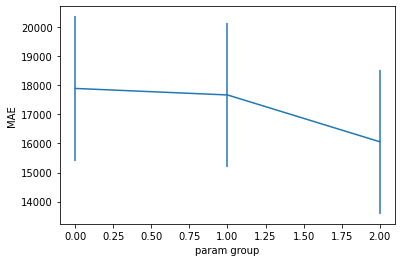

In [43]:
plot_cv_results(gs.cv_results_)

In [44]:
analyze_cv_results(gs.cv_results_)

Parameter group 0: {'estimator': Ridge(alpha=21.54), 'preproc__categorical__encode__min_frequency': 2, 'preproc__numeric__fill_na': SimpleImputer(strategy='most_frequent')}
	Mean score: 17885.12
	95% CI: (16272.11, 19498.13)
------------------------------
Parameter group 1: {'estimator': RandomForestRegressor(), 'preproc__categorical__encode__min_frequency': 2, 'preproc__numeric__fill_na': SimpleImputer(strategy='most_frequent')}
	Mean score: 17662.02
	95% CI: (16542.67, 18781.37)
------------------------------
Parameter group 2: {'estimator': GradientBoostingRegressor(), 'preproc__categorical__encode__min_frequency': 2, 'preproc__numeric__fill_na': SimpleImputer(strategy='most_frequent')}
	Mean score: 16056.59
	95% CI: (15043.17, 17070.01)


Random Forest and Gradient boosting might have an edge, but there's a lot of overlap in the CIs. At this point, one might want to focus on tuning the hyperparameters for the tree-based models.

For now, though, let's see how to implement dimension reduction in our pipeline. 

### Dimension reduction

We can insert a PCA step into our pipeline. 

In [45]:
from sklearn.decomposition import PCA

pipe = Pipeline([
    ('preproc', preproc),
    ('feature_selection', PCA(n_components=10)),
    ('estimator', Ridge(alpha=1))
])

pipe

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('fill_na',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['LotFrontage', 'LotArea',
                                                   'OverallQual', 'OverallCond',
                                                   'YearBuilt', 'YearRemodAdd',
                                                   'MasVnrArea', 'BsmtFinSF1',
                                                   'BsmtFinSF2', 'BsmtUnfSF',
                                                   'TotalBsmtSF', '1stFlrSF',
                                                   '2ndFlrSF', 'LowQualFinSF',
                                                   'GrLivAr...
                                                   'Condition2', 'BldgType',
                                                   'HouseStyle', 'RoofStyle',
                                                   'RoofMatl', 'Exterior1st',
                                                   'Exterior2nd', 'MasVnrType',
                                                   'ExterQual', 'ExterCond',
                                                   'Foundation', 'BsmtQual',
                                                   'BsmtCond', 'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', ...])],
                                   verbose_feature_names_out=False)),
                ('feature_selection', PCA(n_components=10)),
                ('estimator', Ridge(alpha=1))])

In [46]:
# now lets fit new pipeline and see how it does
# we add a "passthrough" to the parameter search
param_grid = {
    'preproc__numeric__fill_na': [SimpleImputer(strategy='most_frequent')],
    'preproc__categorical__encode__min_frequency': [2],
    'feature_selection': ["passthrough"] + [PCA(n) for n in range(1,100,10)],
    'estimator__alpha': [21.54]
}

gs = GridSearchCV(pipe, param_grid, cv=cv, n_jobs=10, scoring='neg_mean_absolute_error', verbose=True)
gs.fit(X_train, y_train)
gs.best_estimator_

Fitting 10 folds for each of 11 candidates, totalling 110 fits


Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('fill_na',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['LotFrontage', 'LotArea',
                                                   'OverallQual', 'OverallCond',
                                                   'YearBuilt', 'YearRemodAdd',
                                                   'MasVnrArea', 'BsmtFinSF1',
                                                   'BsmtFinSF2', 'BsmtUnfSF',
                                                   'TotalBsmtSF', '1stFlrSF',
                                                   '2ndFlrSF', 'LowQualFinSF',
                                                   '...
                                                   'Condition2', 'BldgType',
                                                   'HouseStyle', 'RoofStyle',
                                                   'RoofMatl', 'Exterior1st',
                                                   'Exterior2nd', 'MasVnrType',
                                                   'ExterQual', 'ExterCond',
                                                   'Foundation', 'BsmtQual',
                                                   'BsmtCond', 'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', ...])],
                                   verbose_feature_names_out=False)),
                ('feature_selection', 'passthrough'),
                ('estimator', Ridge(alpha=21.54))])

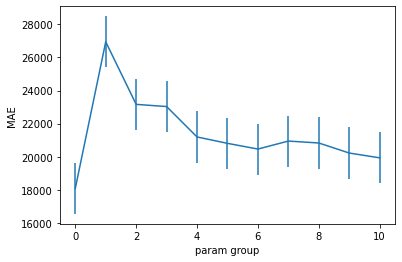

In [47]:
plot_cv_results(gs.cv_results_)

The passthrough variant outperforms all of the PCA variants. Let's try a different feature selection approach. 

In [48]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [49]:
# now lets fit new pipeline and see how it does
# we add a "passthrough" to the parameter search
param_grid = {
    'preproc__numeric__fill_na': [SimpleImputer(strategy='most_frequent')],
    'preproc__categorical__encode__min_frequency': [2],
    'feature_selection': ["passthrough"] + [SelectKBest(f_classif, k=k) for k in range(1, 200, 40)],
    'estimator__alpha': [21.54]
}

gs = GridSearchCV(pipe, param_grid, cv=cv, n_jobs=10, scoring='neg_mean_absolute_error', verbose=True)
gs.fit(X_train, y_train)
gs.best_estimator_

Fitting 10 folds for each of 6 candidates, totalling 60 fits


Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('fill_na',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['LotFrontage', 'LotArea',
                                                   'OverallQual', 'OverallCond',
                                                   'YearBuilt', 'YearRemodAdd',
                                                   'MasVnrArea', 'BsmtFinSF1',
                                                   'BsmtFinSF2', 'BsmtUnfSF',
                                                   'TotalBsmtSF', '1stFlrSF',
                                                   '2ndFlrSF', 'LowQualFinSF',
                                                   '...
                                                   'Condition2', 'BldgType',
                                                   'HouseStyle', 'RoofStyle',
                                                   'RoofMatl', 'Exterior1st',
                                                   'Exterior2nd', 'MasVnrType',
                                                   'ExterQual', 'ExterCond',
                                                   'Foundation', 'BsmtQual',
                                                   'BsmtCond', 'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', ...])],
                                   verbose_feature_names_out=False)),
                ('feature_selection', 'passthrough'),
                ('estimator', Ridge(alpha=21.54))])

Parameter group 0: {'estimator__alpha': 21.54, 'feature_selection': 'passthrough', 'preproc__categorical__encode__min_frequency': 2, 'preproc__numeric__fill_na': SimpleImputer(strategy='most_frequent')}
	Mean score: 18313.82
	95% CI: (15610.21, 21017.43)
------------------------------
Parameter group 1: {'estimator__alpha': 21.54, 'feature_selection': SelectKBest(k=1), 'preproc__categorical__encode__min_frequency': 2, 'preproc__numeric__fill_na': SimpleImputer(strategy='most_frequent')}
	Mean score: 56349.52
	95% CI: (52760.24, 59938.79)
------------------------------
Parameter group 2: {'estimator__alpha': 21.54, 'feature_selection': SelectKBest(k=41), 'preproc__categorical__encode__min_frequency': 2, 'preproc__numeric__fill_na': SimpleImputer(strategy='most_frequent')}
	Mean score: 21874.57
	95% CI: (19566.05, 24183.08)
------------------------------
Parameter group 3: {'estimator__alpha': 21.54, 'feature_selection': SelectKBest(k=81), 'preproc__categorical__encode__min_frequency': 2

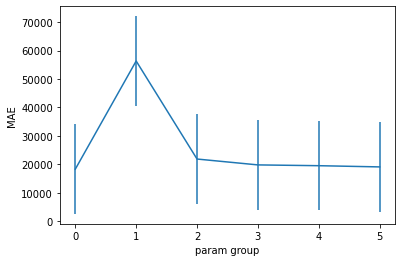

In [50]:
plot_cv_results(gs.cv_results_)
analyze_cv_results(gs.cv_results_)

"passthrough" wins again, though we retain most of the performance using only 41 features. 

## Final Evaluation
We can view the best estimator from the search and evaluate it on the test set. This estimator was selected using cross validation then retrained on the entire train set.  

In [51]:
gs.best_estimator_

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('fill_na',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['LotFrontage', 'LotArea',
                                                   'OverallQual', 'OverallCond',
                                                   'YearBuilt', 'YearRemodAdd',
                                                   'MasVnrArea', 'BsmtFinSF1',
                                                   'BsmtFinSF2', 'BsmtUnfSF',
                                                   'TotalBsmtSF', '1stFlrSF',
                                                   '2ndFlrSF', 'LowQualFinSF',
                                                   '...
                                                   'Condition2', 'BldgType',
                                                   'HouseStyle', 'RoofStyle',
                                                   'RoofMatl', 'Exterior1st',
                                                   'Exterior2nd', 'MasVnrType',
                                                   'ExterQual', 'ExterCond',
                                                   'Foundation', 'BsmtQual',
                                                   'BsmtCond', 'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', ...])],
                                   verbose_feature_names_out=False)),
                ('feature_selection', 'passthrough'),
                ('estimator', Ridge(alpha=21.54))])

In [52]:
# MAE is a more intuitive metric for price estimation
from sklearn.metrics import mean_absolute_error, r2_score

print("First-pass performance:")
print("Train MAE:", mean_absolute_error(y_train, y_train_pred_1stpass))
print("Test MAE:", mean_absolute_error(y_test, y_test_pred_1stpass))
print("Train R^2:", r2_score(y_train, y_train_pred_1stpass))
print("Test R^2:", r2_score(y_test, y_test_pred_1stpass))

y_train_pred = gs.best_estimator_.predict(X_train)
y_test_pred = gs.best_estimator_.predict(X_test)
print("\nFine tuned performance:")
print("Train MAE:", mean_absolute_error(y_train, y_train_pred))
print("Test MAE:", mean_absolute_error(y_test, y_test_pred))
print("Train R^2:", r2_score(y_train, y_train_pred))
print("Test R^2:", r2_score(y_test, y_test_pred))

First-pass performance:
Train MAE: 15288.339516024189
Test MAE: 20544.401602914677
Train R^2: 0.9028881797596011
Test R^2: 0.8714648323729995

Fine tuned performance:
Train MAE: 15485.129766251588
Test MAE: 18672.381852407823
Train R^2: 0.8875868898505703
Test R^2: 0.8765177538936448


## Assignment
If you didn't already, apply the methodology described above to your own dataset. Explore additional ways to improve the model. For instance, 
we saw that [GradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html) had an edge on Ridge regression without any hyperparameter tuning. Explore the hyperparameters for GradientBoostingRegressor on the sklearn documentation page. Define a hyperparameter search using GridSearchCV and use our evaluation methodology to compare the two methods. 